<a href="https://colab.research.google.com/github/prevelat/tf_agents_environment/blob/master/Environment(by_Felipe).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [15]:
!pip install tf-agents-nightly

In [0]:
try:
  %%tensorflow_version 2.x
except:
  pass

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.networks import q_network
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

# HYPERPARAMETERS

In [0]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 10000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval =   50# @param {type:"integer"}

# ENVIRONMENT

For this whole code this is the only part that I did it myself,
as practice/learning all the other parts were based on the
tensorflow agents tutorial by:
https://github.com/tensorflow/agents/tree/master/tf_agents/colabs

In [0]:
class myEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, maximum=5, name='observation')
    self._state = 0
    self._episode_ended = False

    self._reward = 0

    # Make sure it doesn't last forever
    self._max_steps = 1000
    self._n_step = 0

    # Define state/action outcome: destination state and reward 
    self._action_outcome = {
        0: {'up': {'reward': -1, 'dest_state': 0},
            'right': {'reward': 0, 'dest_state': 1},
            'down': {'reward': 0, 'dest_state': 3},
            'left': {'reward': -1, 'dest_state': 0},
        },
        1: {'up': {'reward': -1, 'dest_state': 1},
            'right': {'reward': 0, 'dest_state': 2},
            'down': {'reward': 0, 'dest_state': 4},
            'left': {'reward': 0, 'dest_state': 0},
        },
        2: {'up': {'reward': -1, 'dest_state': 2},
            'right': {'reward': -1, 'dest_state': 2},
            'down': {'reward': 0, 'dest_state': 5},
            'left': {'reward': 0, 'dest_state': 1},
        },
        3: {'up': {'reward': 0, 'dest_state': 0},
            'right': {'reward': 0, 'dest_state': 4},
            'down': {'reward': -1, 'dest_state': 3},
            'left': {'reward': -1, 'dest_state': 3},
        },
        4: {'up': {'reward': 0, 'dest_state': 1},
            'right': {'reward': -5, 'dest_state': 5},
            'down': {'reward': -1, 'dest_state': 4},
            'left': {'reward': 0, 'dest_state': 3},
        },
        5: {'up': {'reward': 10, 'dest_state': 2},
            'right': {'reward': -1, 'dest_state': 5},
            'down': {'reward': -1, 'dest_state': 5},
            'left': {'reward': 0, 'dest_state': 4},
        }
    }

    # Define movement
    self._movement = {
        0: {'direction': 'up', 'action': False},
        1: {'direction': 'right', 'action': False},
        2: {'direction': 'down', 'action': False},
        3: {'direction': 'left', 'action': False}
    }

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = 0
    self._n_step = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _move(self, direction):
    for s in self._action_outcome:
      if s == self._state:
        self._reward = self._action_outcome[s][direction]['reward']
        self._state = self._action_outcome[s][direction]['dest_state']

  def _step(self, action):
    # The last action ended the episode. Ignore the current action and start a new episode.
    if self._state == 2 or self._n_step == self._max_steps:
      return self._reset()

    # Check if action is valid
    if action < 0 or action > 3:
      raise ValueError('`action` should be between 0 or 3')

    # Get direction
    self._movement[int(action)]['action'] = True

    # Move
    self._n_step += 1
    for m in self._movement:
      if self._movement[m]['action'] == True:
        reward = self._move(self._movement[m]['direction'])
        
    # Reset direction
    self._movement[int(action)]['action'] = False

    if self._state == 2 or self._n_step == self._max_steps:
      return ts.termination(np.array([self._state], dtype=np.int32), reward=self._reward)
    else:
      return ts.transition(np.array([self._state], dtype=np.int32), reward=self._reward, discount=0.8)

In [0]:
env = myEnv()
utils.validate_py_environment(env, episodes=100)

In [0]:
train_py_env = myEnv()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

eval_py_env = myEnv()
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# AGENT

In [0]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# POLICIES

In [0]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

# METRICS AND EVALUATION

In [0]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# REPLAY BUFFER

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# DATA COLLECTION

In [0]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=10000)

In [42]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 1), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.int32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [43]:
iterator = iter(dataset)

print(iterator)

# TRAINING

In [44]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 50: Average Return = 8.0
step = 100: Average Return = 8.0
step = 150: Average Return = -1000.0
step = 200: loss = 1.7589154243469238
step = 200: Average Return = 8.0
step = 250: Average Return = -1000.0
step = 300: Average Return = 8.0
step = 350: Average Return = 8.0
step = 400: loss = 1.2600901126861572
step = 400: Average Return = -1000.0
step = 450: Average Return = 8.0
step = 500: Average Return = 8.0
step = 550: Average Return = -1000.0
step = 600: loss = 0.3073885142803192
step = 600: Average Return = 8.0
step = 650: Average Return = 8.0
step = 700: Average Return = 8.0
step = 750: Average Return = 8.0
step = 800: loss = 0.015352899208664894
step = 800: Average Return = 8.0
step = 850: Average Return = 8.0
step = 900: Average Return = 8.0
step = 950: Average Return = 8.0
step = 1000: loss = 0.008574571460485458
step = 1000: Average Return = 8.0
step = 1050: Average Return = 8.0
step = 1100: Average Return = 8.0
step = 1150: Average Return = 8.0
step = 1200: loss = 0.02112

# VISUALIZATION

(-1050.4, 250)

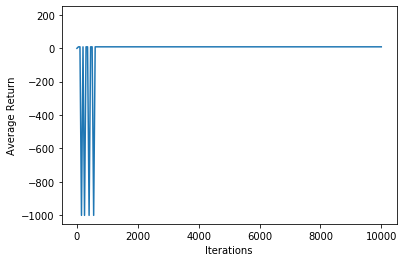

In [45]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [0]:

  # def verbose(self):
    
  #   if self._state == 2:
  #     print("----- END OF EPISODE -----")
  #   else:
  #     print("Current State:", self._state, ", Last Reward:", self._reward)

In [0]:
# hello = {
#     0: {
#         'direction': 'up',
#         'action': False
#     },
#     1: {
#         'direction': 'right',
#         'action': False
#     },
#     2: {
#         'direction': 'down',
#         'action': False
#     },
#     3: {
#         'direction': 'left',
#         'action': False
#     }
# }

# movement = {
#     0: {'direction': 'up', 'action': False},
#     1: {'direction': 'right', 'action': False},
#     2: {'direction': 'down', 'action': False},
#     3: {'direction': 'left', 'action': False}
# }

# action_outcome = {
#     0: {'up': {'reward': -1, 'dest_state': 0},
#         'right': {'reward': 0, 'dest_state': 1},
#         'down': {'reward': 0, 'dest_state': 3},
#         'left': {'reward': -1, 'dest_state': 0},
#     },
#     1: {'up': {'reward': -1, 'dest_state': 1},
#         'right': {'reward': 0, 'dest_state': 2},
#         'down': {'reward': 0, 'dest_state': 4},
#         'left': {'reward': 0, 'dest_state': 0},
#     },
#     2: {'up': {'reward': -1, 'dest_state': 2},
#         'right': {'reward': -1, 'dest_state': 2},
#         'down': {'reward': 0, 'dest_state': 5},
#         'left': {'reward': 0, 'dest_state': 1},
#     },
#     3: {'up': {'reward': 0, 'dest_state': 0},
#         'right': {'reward': 0, 'dest_state': 4},
#         'down': {'reward': -1, 'dest_state': 3},
#         'left': {'reward': -1, 'dest_state': 3},
#     },
#     4: {'up': {'reward': 0, 'dest_state': 1},
#         'right': {'reward': -5, 'dest_state': 5},
#         'down': {'reward': -1, 'dest_state': 4},
#         'left': {'reward': 0, 'dest_state': 3},
#     },
#     5: {'up': {'reward': 10, 'dest_state': 2},
#         'right': {'reward': -1, 'dest_state': 5},
#         'down': {'reward': -1, 'dest_state': 5},
#         'left': {'reward': 0, 'dest_state': 4},
#     }
# }

# state = 0

In [0]:
# action = 0

In [0]:
# hello[int(action)]['action'] = True

# hello

In [0]:
# def move(direction):
#   for s in action_outcome:
#     if s == state:
#       print(action_outcome[s][direction]['reward'], action_outcome[s][direction]['dest_state'])

#   print(direction)
  # for d in self._action_outcome:
  #   if d == direction:
  #     self._reward = d['reward']
  #     self._state = d['dest_state']

# for m in hello:
#   if hello[m]['action'] == True:
#     move(hello[m]['direction'])